In [1]:
import numpy as np
import strawberryfields as sf
import matplotlib
import matplotlib.pyplot as plt
from utils import *

%matplotlib widget

sf.hbar = 1

## Test of analytical result in Lemma 2 Appendix A


In [2]:
def G1(q, mu, Q):
    return np.exp(-(q-mu)**2/2 * Q)

def G2(q, mu, Q):
    return np.exp(-((q[0]-mu[0])**2*Q[0, 0] + (q[1]-mu[1])**2*Q[1, 1] + 2*(q[0]-mu[0])*(q[1]-mu[1])*Q[0, 1]) / 2)

qs = np.linspace(-10, 10, 1000)
rng = np.random.default_rng(1)
failed_cases = 0
samples = 100
print(f"Now checking the formula for a total of {samples} randomly sampled cases.")
for i in range(samples):
    mu = (rng.random()-0.5) * 6
    q = 1/(rng.random()*2)
    mu_vec = (rng.random(2)-0.5) * 6
    
    Q = np.diag(1/(rng.random(2)*2))
    theta = rng.random()*2*np.pi
    O = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    Q = O.T @ Q @ O

    # Numeric result
    g1 = G1(qs, mu, q)
    g2 = G2(np.meshgrid(qs, qs, indexing='ij'), mu_vec, Q)
    integrand = np.einsum("i, ij -> ij", g1, g2)
    I_numeric = np.trapezoid(integrand, qs, axis=0) / np.sqrt(2*np.pi)

    # Analytic result
    detQ = np.linalg.det(Q)
    n = np.sqrt(q + Q[0, 0])
    rho_sqrd = 1/q + Q[1,1]/detQ
    nu = mu_vec[1] + q*Q[0,1]/(detQ + q*Q[1,1]) * (mu_vec[0] - mu)
    sigma_sqrd = (Q[0, 0] + q) / (detQ + q*Q[1,1])
    g1 = G1(mu_vec[0] - mu, 0, 1/rho_sqrd)
    g2 = G1(qs, nu, 1/sigma_sqrd)
    I_analytic = 1/n * g1 * g2
    
    if not np.allclose(I_numeric, I_analytic):
        print("Not equal distributions:", i)
    
    norm = np.trapezoid(I_numeric, qs)
    mean = np.trapezoid(I_numeric/norm * qs, qs)
    var = np.trapezoid(I_numeric/norm * (qs - mean)**2, qs)
    var2 = sigma_sqrd
    
    if not np.isclose(var, var2):
        print("Not the right width:", i, var, var2)
        failed_cases += 1
    if i % 10 == 9:
        print(i+1)

print("Test succeeded:", failed_cases == 0)
print("Number of cases that failed:", failed_cases)

Now checking the formula for a total of 100 randomly sampled cases.
10
20
30
40
50
60
70
80
90
100
Test succeeded: True
Number of cases that failed: 0


## Test of analytical result for the width post Steane type EC

In [3]:
# Simulate Steane type GKP error correction using the Hadamard state as input state with squared 
# width epsilon_in and using ancilla GKP states with squared width epsilon_ancilla
epsilon_in = 0.1
epsilon_ancilla = 0.08

def sim_fast():
    # Fast simulation of Steane-type projection operator using eq. (25)
    qs = np.linspace(-20, 20, 1000)
    zero = normalise(qs, gkp(qs, epsilon_ancilla, state=[1, 0]))
    state_in = normalise(qs, gkp(qs, epsilon_in, state=[np.cos(np.pi/8), np.sin(np.pi/8)]))
    state_q = normalise(qs, gkp_project_asym(qs, state_in, zero))
    state_p = fourier(qs, state_q)
    return qs, state_q, state_p

def sim_sf():
    # (Slow) Simulation using StrawberryFields
    measurement_results = [0, 0]
    ampl_cutoff = 1e-2
    # Steane type EC
    prog = sf.Program(3)
    with prog.context as modes:
        sf.ops.GKP([np.pi/4, 0], epsilon_in, ampl_cutoff=ampl_cutoff) | modes[0]

        sf.ops.GKP([0, 0], epsilon_ancilla, ampl_cutoff=ampl_cutoff) | modes[1]
        sf.ops.GKP([0, 0], epsilon_ancilla, ampl_cutoff=ampl_cutoff) | modes[2]
        sf.ops.Rgate(np.pi) | modes[2]

        sf.ops.CZgate() | (modes[0], modes[1])
        sf.ops.Rgate(-np.pi/2) | modes[0]
        sf.ops.CZgate() | (modes[0], modes[2])
        sf.ops.Rgate(+np.pi/2) | modes[0]

        sf.ops.MeasureHomodyne(np.pi/2, select=measurement_results[0]) | modes[1]
        sf.ops.MeasureHomodyne(np.pi/2, select=measurement_results[1]) | modes[2]

        s = measurement_results[0] + 1j*measurement_results[1]
        sf.ops.Dgate(np.abs(s)/np.sqrt(2), np.angle(s) + np.pi) | modes[0]

    print("Simulating circuit")
    eng = sf.Engine("bosonic")
    result = eng.run(prog)

    print("Computing Wigner function.\nThis might take a while...")
    qs = np.linspace(-10, 10, 200)
    wigner = result.state.wigner(0, qs, qs)
    state_q = np.sqrt(np.clip(np.trapezoid(wigner, qs, axis=0), 0, np.inf))
    state_p = np.sqrt(np.clip(np.trapezoid(wigner, qs, axis=1), 0, np.inf))
    return qs, state_q, state_p

In [4]:
# Choose one of either the fast simulation using eq. (25) or slow simulation using StrawberryFields

qs, state_q, state_p = sim_fast()
# qs, state_q, state_p = sim_sf()

In [5]:
# Fit linear combination of Gaussians on the GKP lattice
from scipy.optimize import curve_fit

def gaussian(x, mu, sigma):
    return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / (np.sqrt(2 * np.pi) * sigma)

def sum_of_gaussians(x, *params):
    n = (len(params) // 2)
    a = params[:n]  # Weights
    sigma = params[n:]  # Widths
    mu = (np.arange(n) - (n - 1) // 2) * np.sqrt(np.pi)  # Fixed means

    y = np.zeros_like(x)
    for i in range(n):
        y += a[i] * gaussian(x, mu[i], sigma[i])
    return y

def fit_gaussians(array):
    # Initial guess
    n_gaussians = 9
    initial_guess = np.hstack([np.ones(n_gaussians), np.ones(n_gaussians)*epsilon_ancilla**0.5])  # Initial weights and widths

    # Fit the state
    x_data = qs
    y_data = np.abs(array)
    popt, _ = curve_fit(sum_of_gaussians, x_data, y_data, p0=initial_guess)

    # Extract fitted parameters
    fitted_weights = popt[:n_gaussians]
    fitted_sigmas = popt[n_gaussians:]

    # Compute variance in widths
    filtered_sigmas = [s for s, w in zip(fitted_sigmas, fitted_weights) if w > 0.05]
    sigma_mean = np.mean(filtered_sigmas)
    sigma_std = np.std(filtered_sigmas)

    print("Output width (numerical):", sigma_mean**2)

    return popt

Input state width:         0.1
Ancilla state width:       0.08
Output width (analytical): 0.12444444444444445
Output width (numerical): 0.12517092292321713


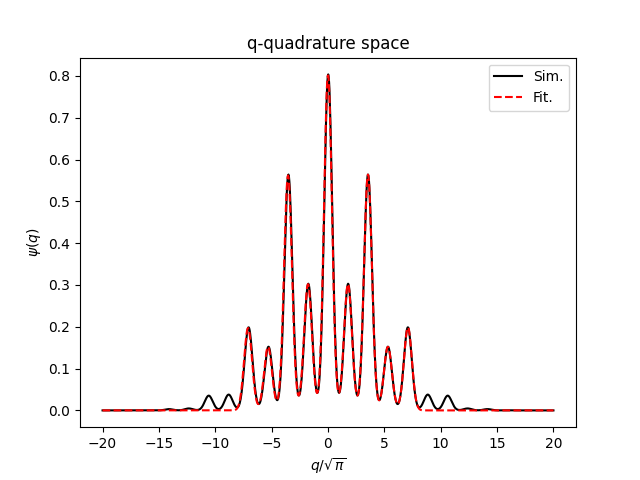

Input state width:         0.1
Ancilla state width:       0.08
Output width (analytical): 0.055384615384615386
Output width (numerical): 0.0559976416918092


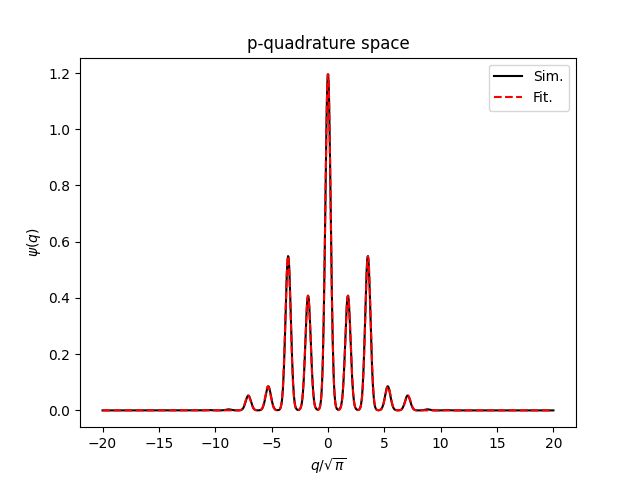

In [6]:
# Plot data and fit for q quadrature
print("Input state width:        ", epsilon_in)
print("Ancilla state width:      ", epsilon_ancilla)
x = epsilon_in / epsilon_ancilla
exp2r = (1 + 2*x) / (1 + x)
print("Output width (analytical):", epsilon_ancilla * exp2r)
fs = np.abs(state_q)
params = fit_gaussians(fs)

plt.figure()
plt.title('q-quadrature space')
plt.plot(qs, fs, 'k-', label='Sim.')
plt.plot(qs, sum_of_gaussians(qs, *params), 'r--', label='Fit.')
plt.xlabel(r"$q/\sqrt{\pi}$")
plt.ylabel(r'$\psi(q)$')
plt.legend()
plt.show()

# Plot data and fit for q quadrature
print("Input state width:        ", epsilon_in)
print("Ancilla state width:      ", epsilon_ancilla)
y = epsilon_in / epsilon_ancilla
exp2r = (1 + y) / (2 + y)
print("Output width (analytical):", epsilon_ancilla * exp2r)
fs = np.abs(state_p)
params = fit_gaussians(fs)

plt.figure()
plt.title('p-quadrature space')
plt.plot(qs, fs, 'k-', label='Sim.')
plt.plot(qs, sum_of_gaussians(qs, *params), 'r--', label='Fit.')
plt.xlabel(r"$q/\sqrt{\pi}$")
plt.ylabel(r'$\psi(q)$')
plt.legend()
plt.show()